In [1]:
import pandas as pd
import numpy as np
import uci_dataset as database
import torch

import raimitigations.dataprocessing as dp
from raimitigations.utils import split_data, train_model_plot_results

# Case Study 1

This notebook shows an example of how to use the **dataprocessing** library. Here, we show how to use this library to explore and transform a dataset with the goal to improve a model's accuracy. Here, we will work with the breast cancer dataset. The dataset is automatically fetched by using the **uci_dataset** library.

## Fixing a seed

To avoid randomness in the following experiments, we'll fix the seeds to guarantee that the results obtained are the same each time we run this notebook. Feel free to comment the next cell or test different seeds to see how this affects the results.

In [2]:
import random
SEED = 45
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

## 1 - Understanding the Data

In [3]:
df = database.load_breast_cancer()
label_col = "Class"
df

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no
...,...,...,...,...,...,...,...,...,...,...
281,recurrence-events,30-39,premeno,30-34,0-2,no,2,left,left_up,no
282,recurrence-events,30-39,premeno,20-24,0-2,no,3,left,left_up,yes
283,recurrence-events,60-69,ge40,20-24,0-2,no,1,right,left_up,no
284,recurrence-events,40-49,ge40,30-34,3-5,no,3,left,left_low,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    278 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  285 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


There are several categorical data in this dataset. Actually, only one feature is numeric, while the remaining columns are all categorical. Therefore, we should take a closer look at each column in order to determine which encoding method should be used to each one. From the summary of the dataset, presented two cells up, we notice that many of the categorical classes doesn't present any order. For these, we should use One-Hot encoding. However, some of these columns present some order among their categories. For example, the **age** column presents a hierarchical information. Let's take a look a these ordered categorical data:

In [5]:
print(f"age unique values = {df['age'].unique()}")
print(f"tumor-size unique values = {df['tumor-size'].unique()}")
print(f"inv-nodes unique values = {df['inv-nodes'].unique()}")

age unique values = ['30-39' '40-49' '60-69' '50-59' '70-79' '20-29']
tumor-size unique values = ['30-34' '20-24' '15-19' '0-4' '25-29' '50-54' '10-14' '40-44' '35-39'
 '5-9' '45-49']
inv-nodes unique values = ['0-2' '6-8' '9-11' '3-5' '15-17' '12-14' '24-26']


After a few cells, we will use this information when encoding our data.

Before modifying the dataset, let's analyze the correlations within its columns. To do that, let's use the **CorrelatedFeatures** class, which computes the correlation between numerical x numerical, categorical x numerical, and categorical x categorical data. Please refer to the notebook in **notebooks/module_tests/feat_sel_corr_tutorial.ipynb** for an in depth analysis of this class. In a nutshell: this class will compute the correlation between all pairs of variables (or we can look only to a specific set of variables if needed) and remove one variable for each pair of correlated variables. This class uses a fit method to compute the correlations and a transform method to effectively remove the correlated variables. For now, we are only interested in analysing the correlations between the columns. We will save the results found by this class in the files specified by *json_summary*, *json_corr*, and *json_uncorr*, respectively. 

In [6]:
cor_feat = dp.CorrelatedFeatures(
					method_num_num=["spearman", "pearson", "kendall"],				# Used for Numerical x Numerical correlations
					num_corr_th=0.9,												# Used for Numerical x Numerical correlations
					num_pvalue_th=0.05,												# Used for Numerical x Numerical correlations
					method_num_cat="model",											# Used for Numerical x Categorical correlations
					model_metrics=["f1", "auc"],									# Used for Numerical x Categorical correlations
					metric_th=0.9,													# Used for Numerical x Categorical correlations
					cat_corr_th=0.9,												# Used for Categorical x Categorical correlations
					cat_pvalue_th=0.01,												# Used for Categorical x Categorical correlations
					json_summary="./corr_json/c1_summary.json",
					json_corr="./corr_json/c1_corr.json",
					json_uncorr="./corr_json/c1_uncorr.json"
				)
cor_feat.fit(df=df, label_col=label_col)

No correlations detected. Nothing to be done here.


Remember to look through the JSON files generated in the previous cell.

## 2 - Basic Pre-Processing

### Encode Categorical Variables

The next step is crucial for preparing our dataset so it can be used by a model. As previously mentioned, we will encode the data using two encoding methods: ordinal encoding for categorical columns with ordered categories, and one-hot encoding for unordered categorical data. The columns "age", "tumor-size", "inv-nodes", and "Class" will all be encoded using ordinal encoding. For the "age", "tumor-size", and "inv-nodes" columns, we provide a list with the ordered categories, which shows the encoder how it should order the encoding numbers (lower values will be associated to the initial categories, while higher encoding values will be associated to the final categories). After creating the encoder object from the **EncoderOrdinal** class, we call its fit method while passing the dataset **df** to it. We then call the transform method, which returns a new copy of the dataset with the categorical columns specified encoded using ordinal encoding. We then proceed to perform the one-hot encoding by instantiating an object of class **EncoderOHE** and then calling its fit and transform methods.

In [7]:
# Set the order that the ordinal encoder should use
age_order = df['age'].unique()
age_order.sort()
tumor_size_order = df['tumor-size'].unique()
tumor_size_order.sort()
inv_nodes_order = df['inv-nodes'].unique()
inv_nodes_order.sort()

# Encode 'tumor-size', 'Class', and 'inv-nodes' using ordinal encoding
enc_ord = dp.EncoderOrdinal(col_encode=["age", "tumor-size", "inv-nodes", "Class"],
							categories={"age":age_order,
										"tumor-size":tumor_size_order, 
										"inv-nodes":inv_nodes_order}
						)
enc_ord.fit(df)
proc_df = enc_ord.transform(df)

# Encode the remaining categorical columns using One-Hot Encoding
enc_ohe = dp.EncoderOHE()
enc_ohe.fit(proc_df)
proc_df = enc_ohe.transform(proc_df)
proc_df

No columns specified for encoding. These columns have been automatically identfied as the following:
['menopause', 'node-caps', 'breast', 'breast-quad', 'irradiat']


,Class,age,tumor-size,inv-nodes,deg-malig,menopause_lt40,menopause_premeno,node-caps_yes,node-caps_nan,breast_right,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,breast-quad_nan,irradiat_yes
0,0,1,5,0,3,0,1,0,0,0,1,0,0,0,0,0
1,0,2,3,0,2,0,1,0,0,1,0,0,0,1,0,0
2,0,2,3,0,2,0,1,0,0,0,1,0,0,0,0,0
3,0,4,2,0,2,0,0,0,0,1,0,1,0,0,0,0
4,0,2,0,0,2,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,1,1,5,0,2,0,1,0,0,0,0,1,0,0,0,0
282,1,1,3,0,3,0,1,0,0,0,0,1,0,0,0,1
283,1,4,3,0,1,0,0,0,0,1,0,1,0,0,0,0
284,1,2,5,4,3,0,0,0,0,0,1,0,0,0,0,0


We can now check that our dataset has only numerical columns in it.

In [8]:
proc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Class                  286 non-null    int64
 1   age                    286 non-null    int64
 2   tumor-size             286 non-null    int64
 3   inv-nodes              286 non-null    int64
 4   deg-malig              286 non-null    int64
 5   menopause_lt40         286 non-null    int64
 6   menopause_premeno      286 non-null    int64
 7   node-caps_yes          286 non-null    int64
 8   node-caps_nan          286 non-null    int64
 9   breast_right           286 non-null    int64
 10  breast-quad_left_low   286 non-null    int64
 11  breast-quad_left_up    286 non-null    int64
 12  breast-quad_right_low  286 non-null    int64
 13  breast-quad_right_up   286 non-null    int64
 14  breast-quad_nan        286 non-null    int64
 15  irradiat_yes           286 non-null    i

### Impute Missing Data and Split Dataset

The next step consists on doing the following:

* split the dataset into train and test sets;
* impute any missing data (if any).

In [9]:
train_x, test_x, train_y, test_y = split_data(proc_df, label_col, test_size=0.25)

imputer = dp.BasicImputer()
imputer.fit(train_x)
train_x = imputer.transform(train_x)
test_x = imputer.transform(test_x)
train_x

No columns specified for imputation. These columns have been automatically identified:
[]


,age,tumor-size,inv-nodes,deg-malig,menopause_lt40,menopause_premeno,node-caps_yes,node-caps_nan,breast_right,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,breast-quad_nan,irradiat_yes
165,2,3,4,2,0,1,0,0,1,0,1,0,0,0,0
79,2,4,0,2,0,1,0,0,1,0,0,0,0,0,0
278,3,6,2,3,0,1,1,0,1,0,0,0,1,0,0
247,3,5,6,3,0,0,1,0,0,0,0,1,0,0,1
248,4,6,5,3,0,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2,2,0,2,0,1,0,0,0,0,1,0,0,0,0
135,1,3,4,2,0,1,0,0,1,0,0,0,0,0,0
258,3,5,5,2,0,0,1,0,0,0,0,1,0,0,1
78,3,4,0,2,0,1,0,0,0,1,0,0,0,0,0


As we can see, the dataset didn't have any missing values. Therefore, the BasicImputer didn't do anything.

## 3 - Baseline Models

In the following cells, we train different models and plot their results over the test set. These models will be considered our baseline models. We will test 2 models as our baseline: XGBoost and K-Nearest Neighbors (KNN).

------------
TEST
------------
[[26 25]
 [ 4 17]]


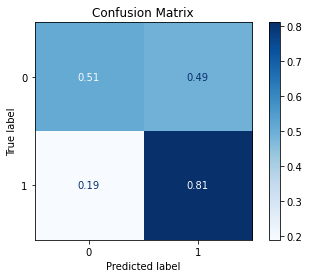

Acuracy: 59.72%

Precision:  0.6357142857142857

Recall:  0.6596638655462185

F1 =  0.5908289241622575

ROC AUC =  0.704014939309057


In [10]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="xgb", train_result=False, plot_pr=False)

------------
TEST
------------
[[19 32]
 [ 4 17]]


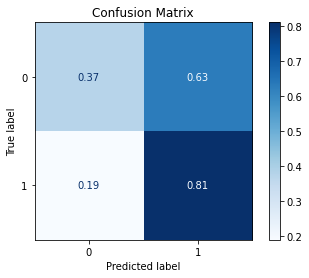

Acuracy: 50.00%

Precision:  0.5865128660159716

Recall:  0.5910364145658263

F1 =  0.49961389961389957

ROC AUC =  0.6087768440709618


In [11]:
model = train_model_plot_results(train_x, train_y, test_x, test_y, model="knn", train_result=False, plot_pr=False)

## 4 - Feature Selection

From this point on, we will try to improve (even if slightly) the results of the baseline models. But before jumping into these improvements, an important note: there is some randomness involved in the training process we showed so far due to two factors:

* the train and test split;
* the model's training process might involve some randomness.

Therefore, if you re-run this notebook with different `SEED` values, you most probably will get different results. Given the small size of the dataset being used here, the split between train and test sets can be crucial for getting good results. This means that some seed values might have results considerably better than others. Keep that in mind when looking through these results and testing different seeds (try commenting the cell where we fix the random seeds to check how the results vary). To really test the efficiency of the preprocessing steps shown here, we could run the split and train steps several times and record the mean (and standard deviation) of the results (auc, f1, etc.). This would give us a more powerful result. We encourage the interested user to check the notebook called **notebooks/case_study/case1_stat.ipynb**, which is a notebook where we perform the test previously described.

Now, let's get back to our more simple experiments. Since we are using the same train and test split used by the baseline models, then we are good to go. Our first preprocessing (not considering the encoding part and the imputations, since those are mandatory to run the baseline models) is feature selection. Here, we will try the feature selection using the CatBoost model by using the **CatBoostSelection** class. Remember that we must pass the training set to the fit method, and then call the transform method over the training and test sets. This way we don't use any information of the test set for this step, avoiding data contamination.

In [12]:
feat_sel = dp.CatBoostSelection(steps=5, verbose=False)
feat_sel.fit(X=train_x, y=train_y)
train_x_sel = feat_sel.transform(train_x)
test_x_sel = feat_sel.transform(test_x)

Let's print the selected features:

In [13]:
feat_sel.get_selected_features()

['tumor-size',
 'inv-nodes',
 'deg-malig',
 'menopause_lt40',
 'node-caps_nan',
 'breast-quad_right_up',
 'breast-quad_nan']

Now, let's re-train the KNN model and see how the feature selection preprocessing step affects the results:

------------
TEST
------------
[[45  6]
 [14  7]]


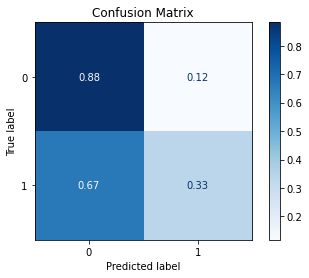

Acuracy: 72.22%

Precision:  0.6505867014341591

Recall:  0.6078431372549019

F1 =  0.6149732620320855

ROC AUC =  0.6321195144724556


In [14]:
model = train_model_plot_results(train_x_sel, train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

Looking at the confusion matrix and comparing it to the baseline KNN model, we can see that the True Positives and True Negatives are now flipped. However, we did get an improvement on the other metrics. Therefore, using feature selection managed to improve the results while using less data (we are now using only 7 columns instead of 9).

## 5 - Synthetic Data

The next preprocessing step we will test is creating synthetic data. We will start by using SMOTE and its variations.

### imblearn Library

The imblearn library implements several variations of SMOTE, a over sampling strategy, as well as some under sampling mehtods, such as TOMEK Links. The class **Rebalance**, present in the **dataprocessing** library, encapsulates the imblearn library and automates certain processes. For example, we don't need to specify which version of SMOTE we want to use. We simply provide the dataset and specify the amount of new data we want, and the class **Rebalance** will do the rest: it will check the dataset and decide the best SMOTE variation to use, apply any under sampling method if requested, and run any preprocessing step if necessary (such as imputation). The user can also explicitly choose which SMOTE version they want by instantiating a SMOTE object (from imblearn) and passing it as a parameter to the **Rebalance** class. The same applies to the under sampling method.

Here, we use the default options provided by the **Rebalance** class regarding the SMOTE method. We choose to not use any under sampling method and we also specify explicitly the number of instances we want for the different values in the Y column.

In [15]:
train_y.value_counts()

0    150
1     64
Name: Class, dtype: int64

Since we got an improved performance when using feature selection, we'll use our new dataset containing only the selected features in the following experiments. Note that these datasets are ``train_x`` and ``test_x``.

In [16]:
rebalance = dp.Rebalance(
				X=train_x_sel,
				y=train_y,
				strategy_over={0:150, 1:90},
				over_sampler=True,
				under_sampler=False
			)
train_x_res, train_y_res = rebalance.fit_resample()
train_y_res.value_counts()

No columns specified for imputation. These columns have been automatically identified:
[]
Running oversampling...
...finished


0    150
1     90
Name: Class, dtype: int64

We can now retrain the KNN model using the new dataset with oversampling:

------------
TEST
------------
[[44  7]
 [12  9]]


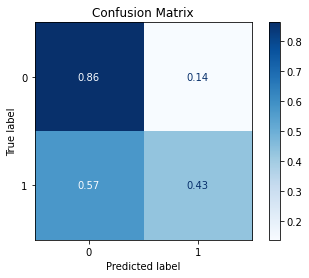

Acuracy: 73.61%

Precision:  0.6741071428571428

Recall:  0.6456582633053222

F1 =  0.6544581965142713

ROC AUC =  0.645658263305322


In [17]:
model = train_model_plot_results(train_x_res, train_y_res, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

As we can see here, the oversampling managed to improve the results for the test set even further (compared to the feature selection step).

### Creating Artificial Data using Deep Learning

Instead of using SMOTE to do the over sampling, we can also use Generator models to create artificial data similar to the ones observed in the training dataset.

#### CTGAN

In the next cell, we use the **Synthesizer** class to create artificial data using the CTGAN model. Similarly to what we've done in the **Rebalance** experiment, we'll use the datasets produced by the feature selection step. We can also try training the CTGAN for more epochs and see how this affects the results.

In [18]:
synth = dp.Synthesizer(
				X=train_x_sel,
				y=train_y,
				epochs=400,
				model="ctgan",
				load_existing=False
			)
synth.fit()
conditions = {label_col:1}
syn_train_x, syn_train_y = synth.transform(X=train_x_sel, y=train_y, n_samples=20, conditions=conditions)
syn_train_y.value_counts()

/home/mmendonca/anaconda3/envs/test3.7/lib/python3.7/site-packages/sklearn/mixture/_base.py:146: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)
/home/mmendonca/anaconda3/envs/test3.7/lib/python3.7/site-packages/sklearn/mixture/_base.py:146: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  .fit(X)
/home/mmendonca/anaconda3/envs/test3.7/lib/python3.7/site-packages/ctgan/data_transformer.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()
/home/mmendonca/anaconda3/envs/test3.7/lib/python3.7/site-packages/ctgan/data_transfo

0    150
1     84
Name: Class, dtype: int64

------------
TEST
------------
[[36 15]
 [ 9 12]]


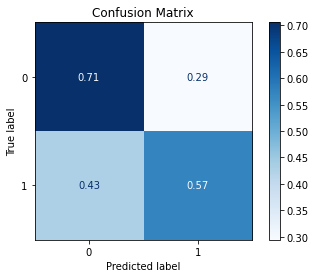

Acuracy: 66.67%

Precision:  0.6222222222222222

Recall:  0.6386554621848739

F1 =  0.625

ROC AUC =  0.6395891690009337


In [19]:
model = train_model_plot_results(syn_train_x, syn_train_y, test_x_sel, test_y, model="knn", train_result=False, plot_pr=False)

Comparing the results to the feature selection step, we notice that the results obtained here are worse for all metrics. Therefore, in this scenario, the CTGAN didn't manage to improve the performance as the **Rebalance** class.

Once again, remember to test different seed values and see how the results will be different.